<a href="https://colab.research.google.com/github/vanditaagarwal/Sentiment_Analysis_of_Company_Reviews/blob/main/DL_Project_Sentiment_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
#import jovian
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data
reviews = pd.read_csv("/content/drive/MyDrive/Company reviews/train.csv")
print(reviews.shape)
reviews.head()

(60000, 3)


,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [ ]:
#keeping only relevant columns and calculating sentence lengths
reviews = reviews[['Review', 'Rating']]
reviews.columns = ['Review', 'Rating']
reviews['review_length'] = reviews['Review'].apply(lambda x: len(x.split()))
reviews.head()

,Review,Rating,review_length
0,Very good value and a great tv very happy and ...,5,18
1,After 6 month still can't access my account,3,8
2,I couldn't make an official review on a produc...,1,92
3,"Fantastic! Extremely easy to use website, fant...",5,32
4,So far annoyed as hell with this bt monthly pa...,1,49


In [ ]:
#changing ratings to 0-numbering
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
reviews['Rating'] = reviews['Rating'].apply(lambda x: zero_numbering[x])

In [ ]:
#mean sentence length
np.mean(reviews['review_length'])

56.56325

In [ ]:
#tokenization
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['Review']))

In [ ]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 29235
num_words after: 16303


In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
reviews['encoded'] = reviews['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
reviews.head()

<ipython-input-12-e8e4138cbc8c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reviews['encoded'] = reviews['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


,Review,Rating,review_length,encoded
0,Very good value and a great tv very happy and ...,4,18,"[[2, 3, 4, 5, 6, 7, 8, 2, 9, 5, 10, 11, 12, 5,..."
1,After 6 month still can't access my account,2,8,"[[17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 0, 0,..."
2,I couldn't make an official review on a produc...,0,92,"[[26, 27, 22, 28, 29, 30, 31, 32, 6, 33, 32, 3..."
3,"Fantastic! Extremely easy to use website, fant...",4,32,"[[87, 39, 88, 89, 62, 90, 91, 39, 87, 92, 93, ..."
4,So far annoyed as hell with this bt monthly pa...,0,49,"[[36, 105, 106, 60, 107, 53, 57, 108, 109, 110..."


In [ ]:
#check how balanced the dataset is
Counter(reviews['Rating'])

Counter({4: 34679, 2: 1679, 0: 18663, 3: 3350, 1: 1629})

In [ ]:
X = list(reviews['encoded'])
y = list(reviews['Rating'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [ ]:
batch_size = 5000
vocab_size = len(words)
print(vocab_size)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

16305


In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model1 =  LSTM_fixed_len(vocab_size, 50, 50)

In [ ]:
class Multilayerlstm_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht,ct) = self.rnn(x)
        return self.linear(ht[-1])

In [ ]:
model2 =  Multilayerlstm_fixed_len(vocab_size, 50, 50, 5)

In [ ]:
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
Train_Loss = []
Train_Acc = []
Val_Loss = []
Val_Acc = []

parameters1 = filter(lambda p: p.requires_grad, model1.parameters())
optimizer1 = torch.optim.Adam(parameters1, lr=0.01)

epochs = 10

for i in range(epochs):
  model1.train()
  sum_loss1 = 0.0
  total1 = 0
  for x, y, l in train_dl:
    x = x.long()
    y = y.long()
    y_pred1 = model1(x, l)
    optimizer1.zero_grad()
    loss1 = F.cross_entropy(y_pred1, y)
    nn.BCEWithLogitsLoss()
    loss1.backward()
    optimizer1.step()
    sum_loss1 += loss1.item()*y.shape[0]
    total1 += y.shape[0]
  val_loss1, val_acc1, val_rmse1 = validation_metrics(model1, val_dl)
  _, train_acc1, _ = validation_metrics(model1, train_dl)
  Train_Acc.append(train_acc1)
  Train_Loss.append(sum_loss1/total1)
  Val_Loss.append(val_loss1)
  Val_Acc.append(val_acc1)
  print("train loss %.3f, train acc %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss1/total1, train_acc1, val_loss1, val_acc1, val_rmse1))
  # return Train_Acc, Train_Loss, Val_Loss, Val_Acc


train loss 1.161, train acc 0.727, val loss 0.869, val accuracy 0.737, and val rmse 1.699
train loss 0.888, train acc 0.729, val loss 0.843, val accuracy 0.737, and val rmse 1.700
train loss 0.851, train acc 0.737, val loss 0.800, val accuracy 0.746, and val rmse 1.653
train loss 0.787, train acc 0.776, val loss 0.716, val accuracy 0.784, and val rmse 1.463
train loss 0.690, train acc 0.826, val loss 0.610, val accuracy 0.825, and val rmse 1.211
train loss 0.581, train acc 0.844, val loss 0.536, val accuracy 0.843, and val rmse 1.073
train loss 0.513, train acc 0.855, val loss 0.495, val accuracy 0.855, and val rmse 0.969
train loss 0.478, train acc 0.864, val loss 0.473, val accuracy 0.860, and val rmse 0.920
train loss 0.455, train acc 0.867, val loss 0.465, val accuracy 0.861, and val rmse 0.911
train loss 0.435, train acc 0.870, val loss 0.457, val accuracy 0.864, and val rmse 0.878


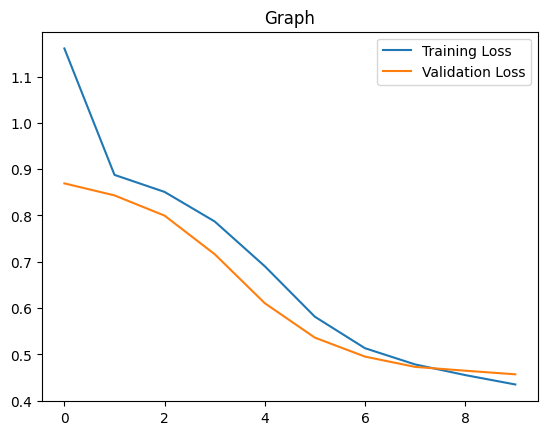

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Loss, label='Training Loss')
plt.plot(Val_Loss, label='Validation Loss')
plt.legend()
plt.title('Graph')
plt.show()

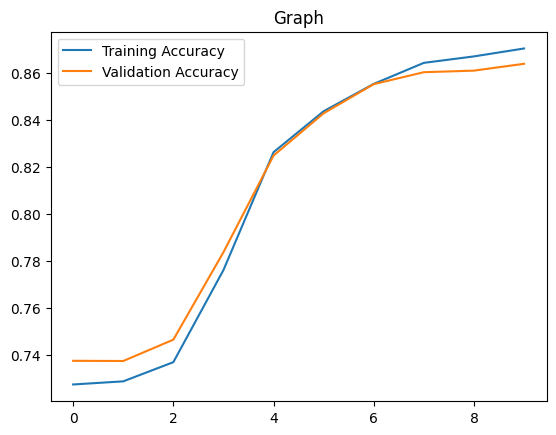

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Acc, label='Training Accuracy')
plt.plot(Val_Acc, label='Validation Accuracy')
plt.legend()
plt.title('Graph')
plt.show()

In [ ]:
Train_Loss1 = []
Train_Acc1 = []
Val_Loss1 = []
Val_Acc1 = []

parameters2 = filter(lambda p: p.requires_grad, model2.parameters())
optimizer2 = torch.optim.Adam(parameters2, lr=0.01)

epochs = 10

for i in range(epochs):
  model2.train()
  sum_loss2 = 0.0
  total2 = 0
  for x, y, l in train_dl:
    x = x.long()
    y = y.long()
    y_pred2 = model2(x, l)
    optimizer2.zero_grad()
    loss2 = F.cross_entropy(y_pred2, y)
    nn.BCEWithLogitsLoss()
    loss2.backward()
    optimizer2.step()
    sum_loss2 += loss2.item()*y.shape[0]
    total2 += y.shape[0]
  val_loss2, val_acc2, val_rmse2 = validation_metrics(model2, val_dl)
  _, train_acc2, _ = validation_metrics(model2, train_dl)
  Train_Acc1.append(train_acc2)
  Train_Loss1.append(sum_loss2/total2)
  Val_Loss1.append(val_loss2)
  Val_Acc1.append(val_acc2)
  print("train loss %.3f, train acc %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss2/total2, train_acc2, val_loss2, val_acc2, val_rmse2))
  # return Train_Acc, Train_Loss, Val_Loss, Val_Acc


train loss 1.170, train acc 0.576, val loss 1.022, val accuracy 0.585, and val rmse 2.313
train loss 1.003, train acc 0.727, val loss 0.878, val accuracy 0.736, and val rmse 1.704
train loss 0.886, train acc 0.729, val loss 0.849, val accuracy 0.740, and val rmse 1.687
train loss 0.852, train acc 0.744, val loss 0.779, val accuracy 0.752, and val rmse 1.627
train loss 0.841, train acc 0.766, val loss 0.749, val accuracy 0.770, and val rmse 1.548
train loss 0.773, train acc 0.746, val loss 0.741, val accuracy 0.748, and val rmse 1.664
train loss 0.769, train acc 0.766, val loss 0.718, val accuracy 0.768, and val rmse 1.563
train loss 0.715, train acc 0.801, val loss 0.669, val accuracy 0.799, and val rmse 1.374
train loss 0.783, train acc 0.809, val loss 0.769, val accuracy 0.809, and val rmse 1.314
train loss 0.748, train acc 0.823, val loss 0.721, val accuracy 0.824, and val rmse 1.213


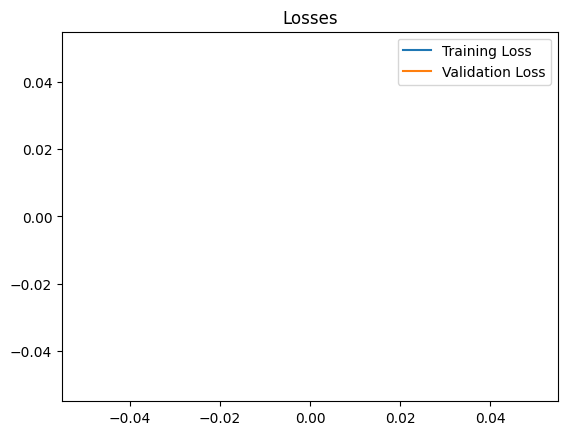

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Loss1, label='Training Loss')
plt.plot(Val_Loss1, label='Validation Loss')
plt.legend()
plt.title('Losses')
plt.show()

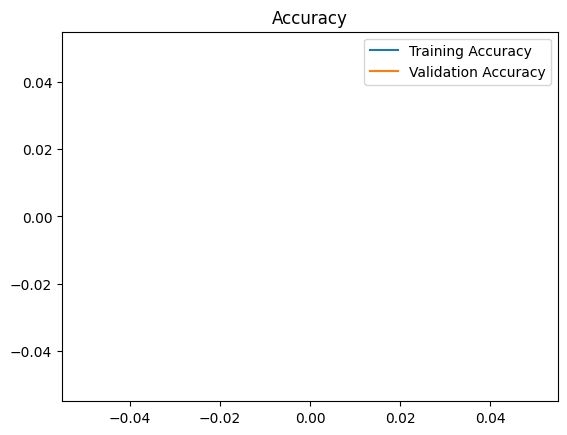

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Acc1, label='Training Accuracy')
plt.plot(Val_Acc1, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()